Defining reusable components

In [41]:
import numpy as np

# Base Layer Class
class Layer:
    def forward(self, inputs):
        raise NotImplementedError

    def backward(self, grad_output):
        raise NotImplementedError

# Fully Connected Layer
class FullyConnectedLayer(Layer):
    def __init__(self, input_size, output_size, initializer):
        self.weights = initializer.initialize((input_size, output_size))
        self.biases = initializer.initialize((1, output_size))
        self.inputs = None

    def forward(self, inputs):
        self.inputs = inputs
        return np.dot(inputs, self.weights) + self.biases

    def backward(self, grad_output):
        grad_inputs = np.dot(grad_output, self.weights.T)
        grad_weights = np.dot(self.inputs.T, grad_output)
        grad_biases = np.sum(grad_output, axis=0, keepdims=True)
        # Update gradients for optimization step
        return grad_inputs, grad_weights, grad_biases

# Base Activation Class
class ActivationFunction:
    def forward(self, inputs):
        raise NotImplementedError

    def backward(self, grad_output):
        raise NotImplementedError

# Example Activation: ReLU
class ReLU(ActivationFunction):
    def forward(self, inputs):
        self.inputs = inputs
        return np.maximum(0, inputs)

    def backward(self, grad_output):
        return grad_output * (self.inputs > 0)

# Weight Initialization Strategies
class Initializer:
    def initialize(self, shape):
        raise NotImplementedError

class XavierInitializer(Initializer):
    def initialize(self, shape):
        return np.random.randn(*shape) * np.sqrt(2 / sum(shape))

# Optimizer Base Class
class Optimizer:
    def update(self, params, grads):
        raise NotImplementedError

class SGD(Optimizer):
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def update(self, params, grads):
        for param, grad in zip(params, grads):
            param -= self.learning_rate * grad



Creating components

Extend for Future Layers and Configurations

In [42]:
# Initialize layers and optimizer
initializer = XavierInitializer()
layer1 = FullyConnectedLayer(input_size=4, output_size=3, initializer=initializer)
layer2 = FullyConnectedLayer(input_size=3, output_size=2, initializer=initializer)
activation = ReLU()
optimizer = SGD(learning_rate=0.01)

# Forward Pass
inputs = np.random.randn(5, 4)  # Batch of 5 samples, 4 features each
layer1_output = layer1.forward(inputs)
activated_output = activation.forward(layer1_output)
layer2_output = layer2.forward(activated_output)

# Chain the operations
final_output = layer2_output

# Simulate a gradient from the next layer (matching the shape of final_output)
grad_from_next_layer = np.random.randn(*final_output.shape)  # Shape: (5, 2)

# Backpropagate through the second layer
grad_inputs2, grad_weights2, grad_biases2 = layer2.backward(grad_from_next_layer)

# Update the second layer
optimizer.update([layer2.weights, layer2.biases], [grad_weights2, grad_biases2])

# Backpropagate through the first layer (via the ReLU activation)
grad_activation = activation.backward(grad_inputs2)
grad_inputs1, grad_weights1, grad_biases1 = layer1.backward(grad_activation)

# Update the first layer
optimizer.update([layer1.weights, layer1.biases], [grad_weights1, grad_biases1])

print(f"Layer1 Output: {layer1_output.shape}, Activated Output: {activated_output.shape}")
print(f"Layer2 Output: {layer2_output.shape}, Grad Next Layer: {grad_from_next_layer.shape}")
print(f"Grad Inputs2: {grad_inputs2.shape}, Grad Weights2: {grad_weights2.shape}, Grad Biases2: {grad_biases2.shape}")



Layer1 Output: (5, 3), Activated Output: (5, 3)
Layer2 Output: (5, 2), Grad Next Layer: (5, 2)
Grad Inputs2: (5, 3), Grad Weights2: (3, 2), Grad Biases2: (1, 2)


Classifying fully connected layers

In [43]:
import numpy as np

class FullyConnectedLayer:
    def __init__(self, input_size, output_size, initializer, optimizer=None):
        """
        Initializes a fully connected layer.

        Parameters:
        - input_size (int): Number of input features.
        - output_size (int): Number of output features.
        - initializer (Initializer): Instance of a weight initialization class.
        - optimizer (Optimizer): Instance of an optimizer class (optional).
        """
        self.W = initializer.initialize((input_size, output_size))  # Weight matrix
        self.B = initializer.initialize((1, output_size))           # Bias vector
        self.optimizer = optimizer                                  # Optimizer instance
        self.X = None                                               # Input placeholder for forward pass

    def forward(self, inputs):
        """
        Perform the forward pass.

        Parameters:
        - inputs (numpy.ndarray): Input matrix of shape (batch_size, input_size).

        Returns:
        - numpy.ndarray: Output matrix of shape (batch_size, output_size).
        """
        self.X = inputs  # Store input for backpropagation
        return np.dot(inputs, self.W) + self.B

    def backward(self, grad_output):
        """
        Perform the backward pass.

        Parameters:
        - grad_output (numpy.ndarray): Gradient from the next layer, shape (batch_size, output_size).

        Returns:
        - numpy.ndarray: Gradient with respect to input (batch_size, input_size).
        """
        # Compute gradients
        grad_W = np.dot(self.X.T, grad_output)   # Gradient w.r.t. weights
        grad_B = np.sum(grad_output, axis=0, keepdims=True)  # Gradient w.r.t. biases
        grad_X = np.dot(grad_output, self.W.T)  # Gradient w.r.t. inputs

        # Update weights and biases using the optimizer if available
        if self.optimizer:
            self.optimizer.update(self, grad_W, grad_B)

        return grad_X  # Return gradient for the input

    def get_params(self):
        """
        Returns the parameters of the layer (weights and biases).
        """
        return [self.W, self.B]

    def set_params(self, new_params):
        """
        Sets the parameters of the layer (weights and biases).

        Parameters:
        - new_params (list): List containing updated weights and biases.
        """
        self.W, self.B = new_params


Initializer class

In [44]:
class XavierInitializer:
    def initialize(self, shape):
        return np.random.randn(*shape) * np.sqrt(2 / sum(shape))


Optimizer class

In [45]:
class SGD:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate

    def update(self, layer, grad_W, grad_B):
        layer.W -= self.learning_rate * grad_W
        layer.B -= self.learning_rate * grad_B


Creating a fully connected Layer

In [47]:
import numpy as np

# Xavier Initializer
class XavierInitializer:
    def initialize_weights(self, input_size, output_size):
        limit = np.sqrt(6 / (input_size + output_size))
        weights = np.random.uniform(-limit, limit, (input_size, output_size))
        biases = np.zeros(output_size)
        return weights, biases

# SGD Optimizer
class SGD:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate

    def update(self, params, grads):
        for param, grad in zip(params, grads):
            param -= self.learning_rate * grad

# Fully Connected Layer
class FullyConnectedLayer:
    def __init__(self, input_size, output_size, initializer):
        self.weights, self.biases = initializer.initialize_weights(input_size, output_size)

    def forward(self, inputs):
        """
        Perform the forward pass.
        Args:
            inputs: Input matrix (batch_size, input_size).
        Returns:
            Output matrix (batch_size, output_size).
        """
        self.inputs = inputs  # Cache inputs for backpropagation
        return np.dot(inputs, self.weights) + self.biases

    def backward(self, grad_output):
        """
        Perform the backward pass.
        Args:
            grad_output: Gradient of loss with respect to the output (batch_size, output_size).
        Returns:
            Tuple containing:
                - Gradient with respect to the input (batch_size, input_size)
                - Gradient with respect to the weights (input_size, output_size)
                - Gradient with respect to the biases (output_size)
        """
        grad_input = np.dot(grad_output, self.weights.T)
        grad_weights = np.dot(self.inputs.T, grad_output)
        grad_biases = np.sum(grad_output, axis=0)
        return grad_input, grad_weights, grad_biases

# Example usage
# Instances of initializer and optimizer
initializer = XavierInitializer()
optimizer = SGD(learning_rate=0.01)

# Create a fully connected layer
fc_layer = FullyConnectedLayer(input_size=4, output_size=3, initializer=initializer)

# Forward pass
inputs = np.random.randn(5, 4)  # Example batch of 5 samples with 4 features each
outputs = fc_layer.forward(inputs)
print("Forward Pass Outputs:\n", outputs)

# Backward pass
grad_output = np.random.randn(5, 3)  # Simulated gradient from the next layer
grad_input, grad_weights, grad_biases = fc_layer.backward(grad_output)
print("Gradient w.r.t Inputs:\n", grad_input)
print("Gradient w.r.t Weights:\n", grad_weights)
print("Gradient w.r.t Biases:\n", grad_biases)

# Update weights and biases using the optimizer
optimizer.update([fc_layer.weights, fc_layer.biases], [grad_weights, grad_biases])
print("Updated Weights:\n", fc_layer.weights)
print("Updated Biases:\n", fc_layer.biases)




Forward Pass Outputs:
 [[-0.31973331  0.63675937  0.60580774]
 [ 1.07582712 -0.6561438  -1.28871631]
 [-0.56442964 -0.75403651 -1.81191234]
 [-0.65732324 -0.96425866 -0.63375865]
 [-0.13428643 -1.28499022  0.54111169]]
Gradient w.r.t Inputs:
 [[-0.92067252  0.85461223 -2.24693049 -1.98085353]
 [ 0.45612944  1.43598383 -0.16278505  0.54434003]
 [-1.00963285  0.0269929  -0.50394769 -0.688163  ]
 [-1.24429414  1.76959983  1.1766489   1.58682597]
 [-0.72959456  0.83944137  0.91523091  1.06195816]]
Gradient w.r.t Weights:
 [[ 5.91294421  1.94627817  4.18090415]
 [ 1.83067954  0.88358623  3.38116893]
 [ 1.1054439  -1.14674005 -1.90051166]
 [-0.0697241   1.62392452 -1.81836941]]
Gradient w.r.t Biases:
 [-3.21324019  2.19607365 -2.86564964]
Updated Weights:
 [[ 0.53516938 -0.12798581  0.41188047]
 [-0.17322952  0.85363508 -0.91834987]
 [ 0.32492916 -0.68748028 -0.60659585]
 [ 0.38512605 -0.34446727 -0.84730335]]
Updated Biases:
 [ 0.0321324  -0.02196074  0.0286565 ]


Classifying the Initialized method

SimpleInitializer Class Implementation

In [ ]:
class SimpleInitializer:
    def __init__(self, sigma=0.01):
        """
        Initializes the SimpleInitializer with a standard deviation value.

        Parameters:
        - sigma (float): Standard deviation for initializing weights and biases.
        """
        self.sigma = sigma

    def initialize(self, shape):
        """
        Generates initialized values for the given shape using a normal distribution.

        Parameters:
        - shape (tuple): Shape of the array to be initialized.

        Returns:
        - numpy.ndarray: Initialized array with the specified shape.
        """
        return np.random.randn(*shape) * self.sigma


Creating a Fully Connected Layer with SimpleInitializer

In [ ]:
# Create an initializer instance with a specific standard deviation
initializer = SimpleInitializer(sigma=0.05)

# Create a fully connected layer using the initializer
fc_layer = FullyConnectedLayer(input_size=4, output_size=3, initializer=initializer)

# Forward pass example
inputs = np.random.randn(5, 4)  # Batch of 5 samples, each with 4 features
outputs = fc_layer.forward(inputs)

print("Outputs:\n", outputs)


Initializing Multiple Layers with Different sigma

In [ ]:
# Layer 1: Higher standard deviation for weights
initializer1 = SimpleInitializer(sigma=0.1)
layer1 = FullyConnectedLayer(input_size=4, output_size=5, initializer=initializer1)

# Layer 2: Lower standard deviation for weights
initializer2 = SimpleInitializer(sigma=0.01)
layer2 = FullyConnectedLayer(input_size=5, output_size=3, initializer=initializer2)


Extending the Initializer Class

In [ ]:
class HeInitializer:
    def initialize(self, shape):
        """
        He Initialization for ReLU-based networks.

        Parameters:
        - shape (tuple): Shape of the array to be initialized.

        Returns:
        - numpy.ndarray: Initialized array with the specified shape.
        """
        return np.random.randn(*shape) * np.sqrt(2 / shape[0])


Classifying optimization methods

FullyConnectedLayer Integration

In [ ]:
class FullyConnectedLayer:
    def __init__(self, input_size, output_size, initializer, optimizer=None):
        """
        Initializes a fully connected layer.

        Parameters:
        - input_size (int): Number of input features.
        - output_size (int): Number of output features.
        - initializer (Initializer): Instance of a weight initialization class.
        - optimizer (Optimizer): Instance of an optimizer class (optional).
        """
        self.W = initializer.initialize((input_size, output_size))  # Weight matrix
        self.B = initializer.initialize((1, output_size))           # Bias vector
        self.optimizer = optimizer                                  # Optimizer instance
        self.X = None                                               # Input placeholder
        self.grad_W = None                                          # Gradient placeholder for weights
        self.grad_B = None                                          # Gradient placeholder for biases

    def forward(self, inputs):
        """
        Perform the forward pass.

        Parameters:
        - inputs (numpy.ndarray): Input matrix of shape (batch_size, input_size).

        Returns:
        - numpy.ndarray: Output matrix of shape (batch_size, output_size).
        """
        self.X = inputs  # Store input for backpropagation
        return np.dot(inputs, self.W) + self.B

    def backward(self, grad_output):
        """
        Perform the backward pass.

        Parameters:
        - grad_output (numpy.ndarray): Gradient from the next layer, shape (batch_size, output_size).

        Returns:
        - numpy.ndarray: Gradient with respect to input (batch_size, input_size).
        """
        # Compute gradients
        self.grad_W = np.dot(self.X.T, grad_output)   # Gradient w.r.t. weights
        self.grad_B = np.sum(grad_output, axis=0, keepdims=True)  # Gradient w.r.t. biases
        grad_X = np.dot(grad_output, self.W.T)  # Gradient w.r.t. inputs

        # Update weights and biases using the optimizer
        if self.optimizer:
            self.optimizer.update(self)

        return grad_X  # Return gradient for the input

# Create an optimizer instance
optimizer = SGD(learning_rate=0.01)
# Creating and Training a fully Connected Layer
# Create an initializer and fully connected layer
initializer = SimpleInitializer(sigma=0.05)
fc_layer = FullyConnectedLayer(input_size=4, output_size=3, initializer=initializer, optimizer=optimizer)

# Forward pass
inputs = np.random.randn(5, 4)  # Batch of 5 samples, each with 4 features
outputs = fc_layer.forward(inputs)

# Backward pass with simulated gradient
grad_output = np.random.randn(5, 3)  # Gradient from the next layer
grad_input = fc_layer.backward(grad_output)

# The weights and biases are updated by the SGD optimizer during the backward pass.


Extending the Optimizer Class

In [ ]:
class Adam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {}  # First moment vector
        self.v = {}  # Second moment vector
        self.t = 0   # Time step

    def update(self, layer):
        if layer not in self.m:
            self.m[layer] = {'W': np.zeros_like(layer.W), 'B': np.zeros_like(layer.B)}
            self.v[layer] = {'W': np.zeros_like(layer.W), 'B': np.zeros_like(layer.B)}

        # Increment time step
        self.t += 1

        # Compute moment estimates
        for param, grad in [('W', layer.grad_W), ('B', layer.grad_B)]:
            self.m[layer][param] = self.beta1 * self.m[layer][param] + (1 - self.beta1) * grad
            self.v[layer][param] = self.beta2 * self.v[layer][param] + (1 - self.beta2) * (grad**2)

            # Bias-corrected estimates
            m_hat = self.m[layer][param] / (1 - self.beta1**self.t)
            v_hat = self.v[layer][param] / (1 - self.beta2**self.t)

            # Update parameters
            param_update = self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)
            setattr(layer, param, getattr(layer, param) - param_update)


Classifying activation methods

In [ ]:
class ActivationFunction:
    def forward(self, inputs):
        """
        Forward pass for the activation function.

        Parameters:
        - inputs (numpy.ndarray): Input matrix.

        Returns:
        - numpy.ndarray: Output after applying the activation function.
        """
        raise NotImplementedError("Forward method must be implemented by subclass.")

    def backward(self, grad_output):
        """
        Backward pass for the activation function.

        Parameters:
        - grad_output (numpy.ndarray): Gradient from the next layer.

        Returns:
        - numpy.ndarray: Gradient w.r.t. input.
        """
        raise NotImplementedError("Backward method must be implemented by subclass.")
# SoftmaxWithCrossEntropy Class Implementation
class SoftmaxWithCrossEntropy:
    def __init__(self):
        self.outputs = None  # Stores softmax outputs during the forward pass
        self.labels = None   # Stores labels during forward pass

    def forward(self, inputs, labels):
        """
        Forward pass for softmax activation and cross-entropy loss calculation.

        Parameters:
        - inputs (numpy.ndarray): Logits of shape (batch_size, num_classes).
        - labels (numpy.ndarray): One-hot encoded labels of shape (batch_size, num_classes).

        Returns:
        - float: Cross-entropy loss.
        """
        # Stabilize logits by subtracting the max value for numerical stability
        exp_logits = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        self.outputs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
        self.labels = labels

        # Compute cross-entropy loss
        batch_size = inputs.shape[0]
        log_probs = -np.log(np.sum(self.outputs * labels, axis=1) + 1e-15)  # Avoid log(0) with epsilon
        return np.sum(log_probs) / batch_size

    def backward(self):
        """
        Backward pass for softmax and cross-entropy loss.

        Returns:
        - numpy.ndarray: Gradient w.r.t. input (batch_size, num_classes).
        """
        # Gradient of the loss w.r.t. logits
        return (self.outputs - self.labels) / self.labels.shape[0]
# SoftmaxWithCrossEntropy Usage
# Inputs: logits from the final layer
logits = np.array([[2.0, 1.0, 0.1],
                   [1.0, 3.0, 0.2]])  # Example input for two samples and three classes

# Labels: one-hot encoded ground truth
labels = np.array([[1, 0, 0],  # Sample 1 belongs to class 0
                   [0, 1, 0]]) # Sample 2 belongs to class 1

# Instantiate the activation/loss function
softmax_ce = SoftmaxWithCrossEntropy()

# Forward pass: compute loss
loss = softmax_ce.forward(logits, labels)
print("Cross-entropy loss:", loss)

# Backward pass: compute gradient
grad_input = softmax_ce.backward()
print("Gradient w.r.t logits:\n", grad_input)


Integration into FullyConnectedLayer

In [17]:
class FullyConnectedLayer:
    def __init__(self, input_size, output_size, initializer, optimizer=None, activation=None):
        self.W = initializer.initialize((input_size, output_size))
        self.B = initializer.initialize((1, output_size))
        self.optimizer = optimizer
        self.activation = activation  # Activation function instance
        self.X = None
        self.Z = None  # Pre-activation output (logits)

    def forward(self, inputs):
        self.X = inputs
        self.Z = np.dot(inputs, self.W) + self.B
        return self.activation.forward(self.Z) if self.activation else self.Z

    def backward(self, grad_output):
        if self.activation:
            grad_output = self.activation.backward(grad_output)

        self.grad_W = np.dot(self.X.T, grad_output)
        self.grad_B = np.sum(grad_output, axis=0, keepdims=True)
        grad_X = np.dot(grad_output, self.W.T)

        if self.optimizer:
            self.optimizer.update(self)

        return grad_X


ReLU class creation

In [ ]:
import numpy as np

class ReLU:
    def __init__(self):
        self.outputs = None  # Store the outputs from the forward pass

    def forward(self, inputs):
        """
        Forward pass for the ReLU activation function.
        Applies the ReLU function element-wise: f(x) = max(0, x).

        Parameters:
        - inputs (numpy.ndarray): Input matrix (batch_size, num_features).

        Returns:
        - numpy.ndarray: Output after applying the ReLU activation function.
        """
        self.outputs = np.maximum(0, inputs)
        return self.outputs

    def backward(self, grad_output):
        """
        Backward pass for the ReLU activation function.
        The gradient of the ReLU is 1 for positive inputs and 0 for non-positive inputs.

        Parameters:
        - grad_output (numpy.ndarray): Gradient from the next layer, shape (batch_size, num_features).

        Returns:
        - numpy.ndarray: Gradient w.r.t input, where the gradient is 0 for non-positive inputs.
        """
        grad_input = grad_output * (self.outputs > 0)  # Apply gradient only where output > 0
        return grad_input


In [18]:
# Create ReLU instance
relu = ReLU()

# Example input matrix
inputs = np.array([[2.0, -1.0, 3.0],
                   [-1.0, 0.0, 1.5]])

# Forward pass
output = relu.forward(inputs)
print("Output after ReLU forward pass:\n", output)

# Backward pass: simulate a gradient from the next layer
grad_output = np.array([[0.1, 0.2, 0.3],
                        [0.4, 0.5, 0.6]])

grad_input = relu.backward(grad_output)
print("Gradient w.r.t. input after ReLU backward pass:\n", grad_input)


Output after ReLU forward pass:
 [[2.  0.  3. ]
 [0.  0.  1.5]]
Gradient w.r.t. input after ReLU backward pass:
 [[0.1 0.  0.3]
 [0.  0.  0.6]]


Initial Value of Weight

In [21]:
import numpy as np

class XavierInitializer:
    def __init__(self):
        pass

    def initialize(self, shape):
        """
        Initialize weights using Xavier (Glorot) initialization.

        Parameters:
        - shape (tuple): The shape of the weights (input_size, output_size).

        Returns:
        - numpy.ndarray: Initialized weights.
        """
        n = shape[0]  # Number of nodes in the previous layer
        stddev = 1.0 / np.sqrt(n)  # Xavier initialization formula
        return np.random.normal(0, stddev, size=shape)

class HeInitializer:
    def __init__(self):
        pass

    def initialize(self, shape):
        """
        Initialize weights using He initialization.

        Parameters:
        - shape (tuple): The shape of the weights (input_size, output_size).

        Returns:
        - numpy.ndarray: Initialized weights.
        """
        n = shape[0]  # Number of nodes in the previous layer
        stddev = np.sqrt(2.0 / n)  # He initialization formula
        return np.random.normal(0, stddev, size=shape)


In [24]:
# Define input size and output size for a layer
input_size = 4
output_size = 3

# Create Xavier and He initializers
xavier_initializer = XavierInitializer()
he_initializer = HeInitializer()

# Initialize weights using Xavier
xavier_weights = xavier_initializer.initialize((input_size, output_size))
print("Xavier Initialized Weights:\n", xavier_weights)

# Initialize weights using He
he_weights = he_initializer.initialize((input_size, output_size))
print("He Initialized Weights:\n", he_weights)


Xavier Initialized Weights:
 [[ 0.72872202 -0.26721785 -0.50897396]
 [ 0.53504873  0.52275683  0.43908358]
 [ 0.99631855  0.86954591 -0.38829869]
 [ 0.19456329 -0.30615643  0.86187223]]
He Initialized Weights:
 [[-0.76494748  0.18054845 -0.26336644]
 [-0.16984039 -0.05613028  1.46249699]
 [-0.35697829  0.26584228  0.739587  ]
 [ 0.66884264 -0.77788412 -0.12103563]]


Optimization Method

In [25]:
import numpy as np

class AdaGrad:
    def __init__(self, learning_rate=0.01):
        """
        Initialize AdaGrad optimizer.

        Parameters:
        - learning_rate (float): The learning rate alpha (default is 0.01).
        """
        self.learning_rate = learning_rate
        self.H = None  # Accumulated squared gradients for weights

    def initialize(self, shape):
        """
        Initialize the accumulator H for the given shape of the weights.

        Parameters:
        - shape (tuple): Shape of the weight matrix (input_size, output_size).
        """
        # Initialize the accumulated squared gradients (H) to zeros
        self.H = np.zeros(shape)

    def update(self, layer):
        """
        Update weights using the AdaGrad algorithm.

        Parameters:
        - layer (object): The layer containing the weights and the gradients.
        """
        # Retrieve gradients (assuming layer has 'dW' for weight gradients)
        grad_w = layer.dW

        # Update the accumulated squared gradients (H)
        self.H += grad_w ** 2

        # Update weights using the AdaGrad update rule
        layer.W -= self.learning_rate * grad_w / (np.sqrt(self.H) + 1e-8)  # Adding epsilon for numerical stability


In [26]:
class Layer:
    def __init__(self, input_size, output_size):
        # Initialize weights with some random values
        self.W = np.random.randn(input_size, output_size)
        self.dW = np.random.randn(input_size, output_size)  # Random gradient for demonstration

# Create a layer with input_size = 4, output_size = 3
layer = Layer(4, 3)

# Create an AdaGrad optimizer instance
adagrad_optimizer = AdaGrad(learning_rate=0.01)

# Initialize the accumulator (H)
adagrad_optimizer.initialize(layer.W.shape)

# Perform a single update (in a training loop, this would be done iteratively)
adagrad_optimizer.update(layer)

# Print updated weights
print("Updated Weights:\n", layer.W)


Updated Weights:
 [[ 1.01384137 -0.18475986  2.13417214]
 [-0.45449998 -0.10871382 -0.69791391]
 [-0.50328538 -1.26871057 -0.77877767]
 [ 3.06209037  0.49428333 -0.64655022]]


Class completion

In [34]:
import numpy as np

class ReLU:
    def forward(self, x):
        """Apply ReLU activation: max(0, x)."""
        self.inputs = x
        return np.maximum(0, x)

    def backward(self, grad_output):
        """Gradient of ReLU: pass gradients where input > 0."""
        return grad_output * (self.inputs > 0)

class XavierInitializer:
    def initialize(self, input_size, output_size):
        """Initialize weights using Xavier initialization."""
        limit = np.sqrt(6 / (input_size + output_size))
        return np.random.uniform(-limit, limit, (input_size, output_size))

class SGD:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate

    def update(self, params, grads):
        """Update parameters using gradients."""
        for param, grad in zip(params, grads):
            param -= self.learning_rate * grad

class FullyConnectedLayer:
    def __init__(self, input_size, output_size, initializer):
        """Initialize weights and biases for the layer."""
        self.weights = initializer.initialize(input_size, output_size)
        self.biases = np.zeros(output_size)

    def forward(self, X):
        """Compute the forward pass for the layer."""
        self.inputs = X
        return np.dot(X, self.weights) + self.biases

    def backward(self, grad_output):
        """Compute the backward pass for the layer."""
        grad_input = np.dot(grad_output, self.weights.T)
        grad_weights = np.dot(self.inputs.T, grad_output)
        grad_biases = np.sum(grad_output, axis=0)
        return grad_input, grad_weights, grad_biases

class NeuralNetwork:
    def __init__(self, layer_configs, initializer, optimizer, activation_functions):
        """Initialize the neural network with given configurations."""
        self.layers = []
        self.activations = activation_functions
        self.optimizer = optimizer

        for i, (input_size, output_size) in enumerate(layer_configs):
            layer = FullyConnectedLayer(input_size, output_size, initializer)
            self.layers.append(layer)

    def forward(self, X):
        """Perform a forward pass through the network."""
        self.inputs = []  # Store inputs to each layer
        self.outputs = []  # Store outputs of each layer

        current_input = X
        for i, layer in enumerate(self.layers):
            self.inputs.append(current_input)
            current_output = layer.forward(current_input)

            # Apply activation function if it's not the last layer
            if i < len(self.activations):
                activation = self.activations[i]
                current_output = activation.forward(current_output)

            self.outputs.append(current_output)
            current_input = current_output

        return current_input

    def backward(self, grad_output):
        """Perform backpropagation through the network."""
        for i in reversed(range(len(self.layers))):
            # Apply gradient to the activation function if it's not the last layer
            if i < len(self.activations):
                grad_output = self.activations[i].backward(grad_output)

            layer = self.layers[i]
            grad_output, grad_weights, grad_biases = layer.backward(grad_output)

            # Update layer weights and biases
            self.optimizer.update([layer.weights, layer.biases], [grad_weights, grad_biases])

    def train(self, X, y, epochs, learning_rate):
        """Train the neural network using gradient descent."""
        for epoch in range(epochs):
            # Forward pass
            predictions = self.forward(X)

            # Compute loss and gradient
            loss, grad_output = self.compute_loss(predictions, y)

            # Backward pass
            self.backward(grad_output)

            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss}")

    def compute_loss(self, predictions, y):
        """Compute loss and gradient for a simple Mean Squared Error loss."""
        loss = np.mean((predictions - y) ** 2)
        grad_output = 2 * (predictions - y) / y.shape[0]
        return loss, grad_output

    def predict(self, X):
        """Predict output for new data."""
        return self.forward(X)

# Initialize components
initializer = XavierInitializer()
optimizer = SGD(learning_rate=0.01)
activation_functions = [ReLU(), ReLU()]

# Define layer configurations
layer_configs = [(4, 5), (5, 3)]

# Create and train the model
nn = NeuralNetwork(layer_configs, initializer, optimizer, activation_functions)

# Dummy data for demonstration
X_train = np.random.randn(100, 4)  # 100 samples, 4 features each
y_train = np.random.randn(100, 3)  # 100 samples, 3 outputs each
X_test = np.random.randn(20, 4)    # 20 samples, 4 features each

# Train the model
nn.train(X_train, y_train, epochs=10, learning_rate=0.01)

# Make predictions
predictions = nn.predict(X_test)
print("Predictions:", predictions)


Epoch 1/10, Loss: 1.1836614089454136
Epoch 2/10, Loss: 1.174716166857344
Epoch 3/10, Loss: 1.166631459379778
Epoch 4/10, Loss: 1.1593066130400276
Epoch 5/10, Loss: 1.1526537121747387
Epoch 6/10, Loss: 1.1467042520862454
Epoch 7/10, Loss: 1.1412247274973286
Epoch 8/10, Loss: 1.13620903015768
Epoch 9/10, Loss: 1.131734097018422
Epoch 10/10, Loss: 1.127619316944517
Predictions: [[0.00000000e+00 7.15029069e-01 0.00000000e+00]
 [0.00000000e+00 4.10402803e-01 0.00000000e+00]
 [0.00000000e+00 1.70162545e-01 0.00000000e+00]
 [0.00000000e+00 1.22979583e+00 1.19485516e-01]
 [0.00000000e+00 8.26823271e-01 0.00000000e+00]
 [8.10143815e-02 8.31693277e-02 1.32454290e-01]
 [1.02534322e-01 5.05682920e-01 3.75470780e-01]
 [0.00000000e+00 1.30071866e-01 0.00000000e+00]
 [0.00000000e+00 2.00253925e+00 0.00000000e+00]
 [6.84559501e-03 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.59746058e-02 1.45888733e-02 0.00000000e+00

Learning and Estimation

Training 1 hidden layer (128 units)...
Accuracy of 1 hidden layer (128 units): 58.43%
Training 2 hidden layers (256, 128 units)...
Accuracy of 2 hidden layers (256, 128 units): 67.27%
Training 3 hidden layers (512, 256, 128 units)...
Accuracy of 3 hidden layers (512, 256, 128 units): 67.63%


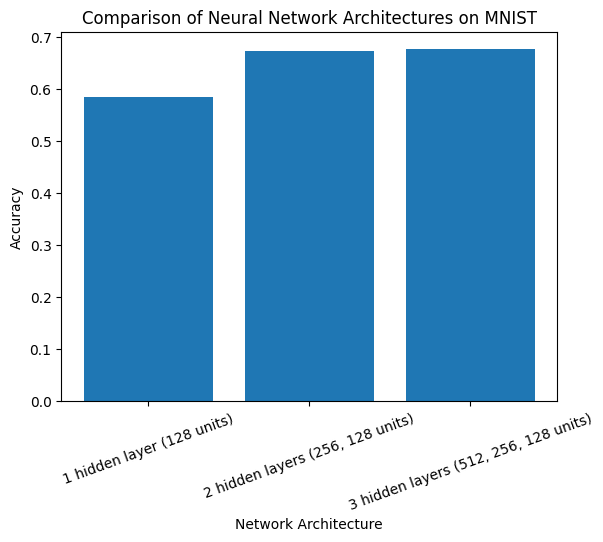

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist
from sklearn.metrics import accuracy_score

# Load and preprocess the MNIST dataset
def load_mnist():
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
    X_test = X_test.reshape(X_test.shape[0], -1) / 255.0

    # One-hot encode the labels
    encoder = OneHotEncoder(sparse_output=False)
    y_train = encoder.fit_transform(y_train.reshape(-1, 1))
    y_test = encoder.transform(y_test.reshape(-1, 1))
    return X_train, y_train, X_test, y_test

# Define activation functions
class Softmax:
    def __call__(self, x):
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))  # Stability improvement
        return exps / np.sum(exps, axis=1, keepdims=True)

class ReLU:
    def __call__(self, x):
        return np.maximum(0, x)

    def derivative(self, x):
        return (x > 0).astype(float)

# Xavier initializer
class XavierInitializer:
    def initialize(self, input_size, output_size):
        return np.random.randn(input_size, output_size) * np.sqrt(1 / input_size)

# Fully connected layer
class FullyConnectedLayer:
    def __init__(self, input_size, output_size, initializer):
        self.weights = initializer.initialize(input_size, output_size)
        self.biases = np.zeros((1, output_size))
        self.inputs = None

    def forward(self, inputs):
        self.inputs = inputs
        return np.dot(inputs, self.weights) + self.biases

    def backward(self, grad_output, optimizer):
        grad_input = np.dot(grad_output, self.weights.T)
        grad_weights = np.dot(self.inputs.T, grad_output)
        grad_biases = np.sum(grad_output, axis=0, keepdims=True)
        optimizer.update(self, grad_weights, grad_biases)
        return grad_input

# AdaGrad optimizer
class AdaGrad:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate
        self.cache = {}

    def update(self, layer, grad_weights, grad_biases):
        # Using id(layer) to make it hashable
        layer_id = id(layer)

        # If the layer's weights are not in cache, initialize them
        if layer_id not in self.cache:
            self.cache[layer_id] = {'weights': np.zeros_like(grad_weights), 'biases': np.zeros_like(grad_biases)}

        # Update cache with squared gradients
        self.cache[layer_id]['weights'] += grad_weights ** 2
        self.cache[layer_id]['biases'] += grad_biases ** 2

        # Compute the adjusted learning rate and update weights
        adjusted_lr_w = self.learning_rate / (np.sqrt(self.cache[layer_id]['weights']) + 1e-7)
        adjusted_lr_b = self.learning_rate / (np.sqrt(self.cache[layer_id]['biases']) + 1e-7)

        layer.weights -= adjusted_lr_w * grad_weights
        layer.biases -= adjusted_lr_b * grad_biases

# Neural network
class NeuralNetwork:
    def __init__(self, layer_configs, initializer, optimizer, activation_functions):
        self.layers = []
        self.activations = activation_functions
        self.optimizer = optimizer

        for i, (input_size, output_size) in enumerate(layer_configs):
            self.layers.append(FullyConnectedLayer(input_size, output_size, initializer))

    def forward(self, inputs):
        output = inputs
        for layer, activation in zip(self.layers, self.activations):
            output = activation(layer.forward(output))
        return output

    def train(self, X, y, epochs):
        for epoch in range(epochs):
            predictions = self.forward(X)
            loss_grad = predictions - y  # Simplified loss: cross-entropy with softmax
            for layer in reversed(self.layers):
                loss_grad = layer.backward(loss_grad, self.optimizer)

    def predict(self, X):
        return self.forward(X)

# Load MNIST data
X_train, y_train, X_test, y_test = load_mnist()

# Define network configurations
layer_configs_1 = [(784, 128), (128, 10)]
activation_functions_1 = [ReLU(), Softmax()]
initializer_1 = XavierInitializer()
optimizer_1 = AdaGrad(learning_rate=0.001)

layer_configs_2 = [(784, 256), (256, 128), (128, 10)]
activation_functions_2 = [ReLU(), ReLU(), Softmax()]
initializer_2 = XavierInitializer()
optimizer_2 = AdaGrad(learning_rate=0.001)

layer_configs_3 = [(784, 512), (512, 256), (256, 128), (128, 10)]
activation_functions_3 = [ReLU(), ReLU(), ReLU(), Softmax()]
initializer_3 = XavierInitializer()
optimizer_3 = AdaGrad(learning_rate=0.001)

# Instantiate and train the models
networks = [
    {"network": NeuralNetwork(layer_configs_1, initializer_1, optimizer_1, activation_functions_1), "name": "1 hidden layer (128 units)"},
    {"network": NeuralNetwork(layer_configs_2, initializer_2, optimizer_2, activation_functions_2), "name": "2 hidden layers (256, 128 units)"},
    {"network": NeuralNetwork(layer_configs_3, initializer_3, optimizer_3, activation_functions_3), "name": "3 hidden layers (512, 256, 128 units)"}
]

# Train and evaluate each model
accuracies = []
for net in networks:
    print(f"Training {net['name']}...")
    net['network'].train(X_train, y_train, epochs=10)

    y_pred_probs = net['network'].predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)
    accuracy = accuracy_score(y_test_labels, y_pred)
    accuracies.append((net['name'], accuracy))
    print(f"Accuracy of {net['name']}: {accuracy * 100:.2f}%")

# Visualize results
names, acc_values = zip(*accuracies)
plt.bar(names, acc_values)
plt.xlabel('Network Architecture')
plt.ylabel('Accuracy')
plt.title('Comparison of Neural Network Architectures on MNIST')
plt.xticks(rotation=20)
plt.show()


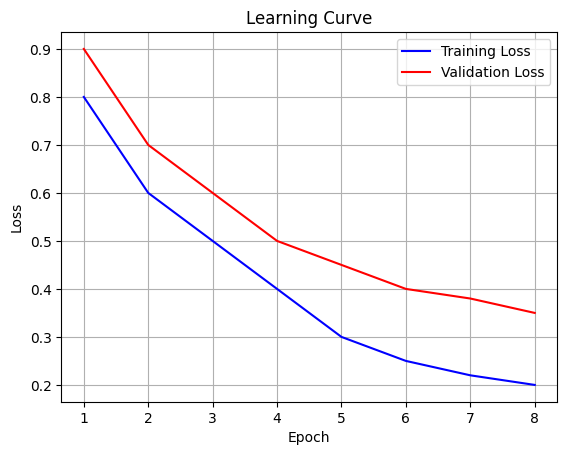

In [32]:
import matplotlib.pyplot as plt

train_loss = [0.8, 0.6, 0.5, 0.4, 0.3, 0.25, 0.22, 0.2] # Example loss values
val_loss = [0.9, 0.7, 0.6, 0.5, 0.45, 0.4, 0.38, 0.35]   # Example loss values

epochs = range(1, len(train_loss) + 1) # Assuming you have loss for each epoch

plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()